a realistic date set that contains both continuous and categorical data

we should able to apply as ANN to our own classification and regression tasks

we also need to discuss about feature engineering, feature encoding, embedding, dropout layers, and more.

ANN can only take in numerical data, probably won't understand direct complex data: a full datetime stamp or latitude measurements

# Coding along project steps:
1. read the data
2. feature engineering: calculate distance, derive useful date and time statistics. deal with the categorical data: embedding. use a tablarmodel class to work with both continuous and categorical data
3. add loss function and optimizer, train test split data
4. train model
5. evaluate on test data
6. predict on brand new data

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [5]:
# its better to get distance between longitude and latitude, using haversine formula

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
df['dist_km'] = haversine_distance(df,'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')

In [8]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km'],
      dtype='object')

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.925522
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.765370
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.818373
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.158661
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.457764


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [13]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.925522
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.765370
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.818373
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.158661
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.457764


In [14]:
mytime = df['pickup_datetime'][0]

In [15]:
mytime

Timestamp('2010-04-19 08:17:56+0000', tz='UTC')

In [16]:
mytime.hour

8

In [17]:
mytime.day_of_week

0

In [18]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours = 3)

In [19]:
df['hour'] = df['EDTdate'].dt.hour

In [20]:
df['AMorPM'] = np.where(df['hour'] < 12, 'AM', 'PM')

In [21]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.925522,2010-04-19 05:17:56+00:00,5,AM
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.765370,2010-04-17 12:43:53+00:00,12,PM
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.818373,2010-04-17 08:23:26+00:00,8,AM
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.158661,2010-04-11 18:25:03+00:00,18,PM
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.457764,2010-04-16 23:19:01+00:00,23,PM


In [22]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a") # dt.dayofweek

In [23]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.925522,2010-04-19 05:17:56+00:00,5,AM,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.765370,2010-04-17 12:43:53+00:00,12,PM,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.818373,2010-04-17 08:23:26+00:00,8,AM,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.158661,2010-04-11 18:25:03+00:00,18,PM,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.457764,2010-04-16 23:19:01+00:00,23,PM,Fri


In [24]:
cat_cols = ['hour', 'AMorPM', 'Weekday']

In [25]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [48]:
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [49]:
y_cols = ['fare_amount']

In [50]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [51]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [52]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [53]:
df['hour'].head()

0     5
1    12
2     8
3    18
4    23
Name: hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [54]:
df['AMorPM'].head()

0    AM
1    PM
2    AM
3    PM
4    PM
Name: AMorPM, dtype: category
Categories (2, object): ['AM', 'PM']

In [55]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [56]:
df['AMorPM'].cat.categories

Index(['AM', 'PM'], dtype='object')

In [57]:
df['AMorPM'].cat.codes

0         0
1         1
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [58]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [59]:
df['Weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [60]:
df['Weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [61]:
hr = df['hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [62]:
hr

array([ 5, 12,  8, ..., 15,  5, 13], dtype=int8)

In [63]:
cats = np.stack([hr, ampm, wkdy], axis = 1) 

In [64]:
# cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

In [65]:
cats

array([[ 5,  0,  1],
       [12,  1,  2],
       [ 8,  0,  2],
       ...,
       [15,  1,  3],
       [ 5,  0,  5],
       [13,  1,  2]], dtype=int8)

In [66]:
cats = torch.tensor(cats, dtype = torch.int64)

In [67]:
cats

tensor([[ 5,  0,  1],
        [12,  1,  2],
        [ 8,  0,  2],
        ...,
        [15,  1,  3],
        [ 5,  0,  5],
        [13,  1,  2]])

In [68]:
conts = np.stack([df[col].values for col in cont_cols], axis = 1)

In [69]:
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   1.92552186],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.76536972],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.81837279],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   2.85952926],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.32066878],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.38476009]])

In [70]:
conts = torch.tensor(conts, dtype = torch.float)

In [71]:
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   1.9255],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.7654],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.8184],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   2.8595],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.3207],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.3848]])

In [72]:
y = torch.tensor(df[y_cols].values, dtype = torch.float).reshape(-1, 1)

In [73]:
cats.shape

torch.Size([120000, 3])

In [74]:
conts.shape

torch.Size([120000, 6])

In [75]:
y.shape

torch.Size([120000, 1])

In [76]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [77]:
cat_szs

[24, 2, 7]

In [78]:
emb_szs = [(size, min(50, (size +1)// 2)) for size in cat_szs]#either take 50 or divided by 2

In [79]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [80]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [81]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200, 100], p = 0.4)

In [82]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [83]:
criterion = nn.MSELoss()# np.sqrt(mse) --> RMSE
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [84]:
batch_size = 60000
test_size = int(batch_size * 0.2)

In [85]:
# data shuffleo already
cat_train = cats[:batch_size - test_size]
cat_test = cats[batch_size - test_size: batch_size]
con_train =conts[:batch_size - test_size]
con_test = conts[batch_size - test_size: batch_size]

In [86]:
y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size: batch_size]

In [87]:
len(cat_train)

48000

In [88]:
len(con_train)

48000

In [89]:
len(cat_test)

12000

In [90]:
import time
start_time = time.time()
epochs = 300
losses = []
for i in range(epochs):
  i += 1
  y_pred = model(cat_train, con_train)
  loss = torch.sqrt(criterion(y_pred, y_train))
  losses.append(loss)

  if i % 10 == 1:
    print(f'epoch: {i} loss is {loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

duration = time.time() - start_time
print(f'Training too {duration/60} minutes')

epoch: 1 loss is 12.595575332641602
epoch: 11 loss is 11.76091480255127
epoch: 21 loss is 11.2423677444458
epoch: 31 loss is 10.893644332885742
epoch: 41 loss is 10.620195388793945
epoch: 51 loss is 10.39820384979248
epoch: 61 loss is 10.17572021484375
epoch: 71 loss is 9.9695405960083
epoch: 81 loss is 9.73521900177002
epoch: 91 loss is 9.472050666809082
epoch: 101 loss is 9.199162483215332
epoch: 111 loss is 8.88756275177002
epoch: 121 loss is 8.548860549926758
epoch: 131 loss is 8.165257453918457
epoch: 141 loss is 7.7502031326293945
epoch: 151 loss is 7.305694580078125
epoch: 161 loss is 6.839813232421875
epoch: 171 loss is 6.354735851287842
epoch: 181 loss is 5.860179901123047
epoch: 191 loss is 5.349670886993408
epoch: 201 loss is 4.92524528503418
epoch: 211 loss is 4.5360565185546875
epoch: 221 loss is 4.272687911987305
epoch: 231 loss is 4.058652400970459
epoch: 241 loss is 3.9121358394622803
epoch: 251 loss is 3.8592216968536377
epoch: 261 loss is 3.779233694076538
epoch: 271 

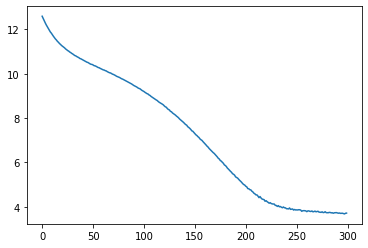

In [91]:
plt.plot(range(epochs), losses)

In [92]:
with torch.no_grad():
  y_val = model(cat_test, con_test)
  loss = torch.sqrt(criterion(y_val, y_test))


In [93]:
loss

tensor(3.6160)

In [101]:
diff_list = []
for i in range(len(y_test)):
  diff = np.abs(y_val[i].item() - y_test[i].item())
  diff_list.append(diff)
  print(f'{i}.) Predicted: {y_val[i].item():8.2f}. TRUE: {y_test[i].item(): 8.2f}. diff: {diff: 8.2f}')

Streaming output truncated to the last 5000 lines.
7000.) Predicted:    14.46. TRUE:    49.57. diff:    35.11
7001.) Predicted:    11.20. TRUE:     8.10. diff:     3.10
7002.) Predicted:     8.37. TRUE:     8.10. diff:     0.27
7003.) Predicted:     7.58. TRUE:     9.30. diff:     1.72
7004.) Predicted:     6.82. TRUE:     6.50. diff:     0.32
7005.) Predicted:     8.10. TRUE:    10.50. diff:     2.40
7006.) Predicted:     5.93. TRUE:     4.50. diff:     1.43
7007.) Predicted:     6.64. TRUE:     7.30. diff:     0.66
7008.) Predicted:    10.87. TRUE:    11.70. diff:     0.83
7009.) Predicted:    14.11. TRUE:     9.30. diff:     4.81
7010.) Predicted:    16.78. TRUE:    24.10. diff:     7.32
7011.) Predicted:    13.50. TRUE:    46.90. diff:    33.40
7012.) Predicted:     7.56. TRUE:    16.50. diff:     8.94
7013.) Predicted:     5.38. TRUE:     4.50. diff:     0.88
7014.) Predicted:    15.90. TRUE:    24.50. diff:     8.60
7015.) Predicted:    10.41. TRUE:    12.90. diff:     2.49
7016.

In [103]:
np.average(diff_list)

2.225560110002756

In [99]:
torch.save(model.state_dict(), 'TaxiModel.pt')